# Understanding How the DataBlock API was Built

In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

In [2]:
from exp.nb_07a import *

In [3]:
# Importing fastai's custom Imagenet dataset, called "Imagenette".
# Bear in mind that Imagenette v2 now has a 70/30 split so values will
# differ from the course notebook.
datasets.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160'

## Building an Image ItemList

Previously, we were reading the whole MNIST dataset into our local RAM at once in pickle format. That can't be done for larger datasets.

From here on out, images will be left on disk and will be loaded according to the mini-batches being used for training.

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/home/bilal/.fastai/data/imagenette2-160')

In [5]:
# We will add the .ls method to the path as a monkey patch
import PIL, os, mimetypes
Path.ls = lambda x: list(x.iterdir())

In [6]:
# Checking if the changes took effect
path.ls()

[PosixPath('/home/bilal/.fastai/data/imagenette2-160/val'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/train')]

In [7]:
# Looking inside our classes folders
(path/'val').ls()

[PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03394916'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03425413'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n01440764'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03000684'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n02979186'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n02102040'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03888257'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03028079'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03445777')]

In [8]:
# Looking inside the Tench class folder
path_tench = path/'val'/'n01440764'

In [9]:
# Assigning a single image
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n01440764/n01440764_5642.JPEG')

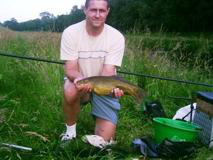

In [10]:
img = PIL.Image.open(img_fn)
img

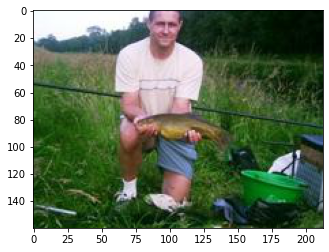

In [11]:
# Plotting dimensions of the image
plt.imshow(img);

We can also check the image dimensions using the standard numpy method.

In [12]:
import numpy as np
img_arr = np.array(img)

In [13]:
img_arr.shape

(160, 213, 3)

- We must be careful about other file types in the directory, for e.g. models, text etc.
- Instead of writing it out by hand, let's use the MIME types database.
- Details of mapping filenames to MIME types can be found Python's [documentation]("https://docs.python.org/2/library/mimetypes.html").

In [14]:
image_extensions = set(k for k,v in mimetypes.types_map.items()\
                       if v.startswith('image/'))

In [15]:
# Here are the image type extensions we will be focusing on
' '.join(image_extensions)

'.ras .xwd .tif .pnm .png .ppm .jpe .jpg .gif .ico .jpeg .tiff .rgb .pbm .svg .xbm .xpm .ief .bmp .pgm'

In [16]:
# Convert items first to a list and then a set
def setify(o):
    return o if isinstance(o, set) else set(listify(o))

In [17]:
# Using the testing framework from previous nbs
test_eq(setify('aa'), {'aa'})
test_eq(setify(['aa',1]), {'aa',1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

- Now that our `setify()` function is ready, we will grab only the image files from the target directories.
- The first private function grabs all the images inside a given directory and the second one "walks" (potentially recursively) through all the folders in the given `path`

In [18]:
# Run through a single directory and grab the images in that
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
          and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [19]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)

In [20]:
t[0:10]

[PosixPath('/home/bilal/.fastai/data/imagenette2-160/n01440764_5642.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/n01440764_13770.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/n01440764_10211.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/n01440764_13821.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/ILSVRC2012_val_00021740.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/n01440764_5081.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/n01440764_4562.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/n01440764_9491.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/n01440764_490.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/n01440764_200.JPEG')]

In [21]:
# Putting all of the above into one function to "get files"
def get_files(path, extensions=None, recurse=False, include=None):
    path=Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): 
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)
            

- `scandir()` is highly optimized as it a "thin" wrapper on top of C's API.
- For recursion, `os.walk()` uses scandir() internally to walk through a folder tree. We can also modify the list of directories it looks at on the fly.

In [22]:
# Testing the get_files function
get_files(path_tench, image_extensions)[:5]

[PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n01440764/n01440764_5642.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n01440764/n01440764_13770.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n01440764/n01440764_10211.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n01440764/n01440764_13821.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n01440764/ILSVRC2012_val_00021740.JPEG')]

The **recurse** argument is needed when we start from `path`, since the pictures are two levels below in directories.

In [23]:
get_files(path, image_extensions, recurse=True)[:5]

[PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042/n03417042_8912.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042/n03417042_9170.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042/n03417042_422.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042/n03417042_8192.JPEG'),
 PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042/n03417042_27231.JPEG')]

In [24]:
# Getting all of the file names 
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

In [25]:
# Let's test the speed of the get_files function
# Bearing in mind that Imagenet is 100 times bigger than imagenette
%timeit -n 10 get_files(path, image_extensions, recurse=True)

38.1 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Data Prep for Modeling

So, our data pipeline will be:
- Getting files
- Splitting the validation set (args will be random%, folder name, ftype, etc.)
- Label the data (steps above)
- Transform per image / Augmentation (optional step)
- Transform to Tensor
- DataLoader
- Transform per batch (optional)
- DataBunch
- Add test set (optional)

### Get Files

- Using the `ListContainer` from before (exp06) to store our objects in the `ItemList`.
- `get` will need to be subclassed to explain how to access an element, then the private `_get` method will allow an additional transform operation.
- `new` will be used in conjunction with `__getitem__` (which works for one index or a list of indeces) to create training and validation sets from a single stream once the data is split.
- We could just put all files into ListContainer but it is much better if we could get the image right away when we call get function. ImageList does this by inheriting ItemList that inherits ListContainer. ItemList is just a function that gets items, path, and transforms. Transforms are called in order (if there is) and the data will be updated so that it rewrites the old data. More about compose: https://en.wikipedia.org/wiki/Function_composition_(computer_science) ImageList in the other hand is a function that opens the images for us when get is called. (Lankinen's Notes)

In [26]:
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key):
        x = f(x, **kwargs)
    return x

class ItemList(ListContainer): # Grab image files and dump them into the ListContainer
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path, self.tfms = Path(path), tfms
        
    def __repr__(self):
        return f'{super().__repr__()}\Path: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None:
            cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def get(self, i): #This default get method will be over-ridden 
        return i
    
    def _get(self, i):
        return compose(self.get(i), self.tfms) #refer to Wikipedia link on compose
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx) #Index into our list, pass it to the container
        if isinstance(res, list): return [self._get(o) for o in res] # Call if list
        return self._get(res) #call if single item
    
class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: 
            extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn):
        return PIL.Image.open(fn)

- Transforms are strictly limited to data augmentation. For total flexibility, `ImageList` returns a raw PIL image. The first step would be to convert it to RGB or some other format.
- Transforms only need to be functions that take an element of the `ItemList` and transform it.
- In order to give them state, they can be defined as a class. Having them as a class allows to define an `_order` attribute(default 0), which is used to sort the transforms.

In [27]:
class Transform():
    _order=0
    
# Both the class and the function do the same thing.
# Obviously, the class can be extended.
class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')
    
def make_rgb(item): 
    return item.convert('RGB')

In [28]:
il = ImageList.from_files(path, tfms=make_rgb)

In [29]:
# __repr__ gives us following print outputs
il

ImageList (13394 items)
[PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042/n03417042_8912.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042/n03417042_9170.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042/n03417042_422.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042/n03417042_8192.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042/n03417042_27231.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042/n03417042_4462.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042/n03417042_12601.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042/n03417042_6480.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042/n03417042_27022.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042/n03417042_6250.JPEG')...]\Path: /home/bilal/.fastai/data/imagenette2-160

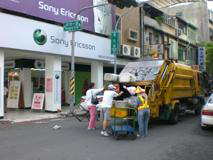

In [30]:
# Indexing into the image list
img = il[1]
img

In [31]:
il[:2] # We can also index with a range of integers 

[<PIL.Image.Image image mode=RGB size=240x160 at 0x7F319DAA1430>,
 <PIL.Image.Image image mode=RGB size=213x160 at 0x7F319DAA1670>]

### Split Validation Set

- The files need to be split between the train and val folders.
- As file names are `path` objects, the file directory can be found with `.parent`.

In [32]:
fn = il.items[0]; fn

PosixPath('/home/bilal/.fastai/data/imagenette2-160/val/n03417042/n03417042_8912.JPEG')

In [33]:
fn.parent.parent.name

'val'

In [34]:
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

def split_by_func(items, f):
    mask = [f(o) for o in items]
    # None values are filtered out
    f = [o for o, m in zip(items, mask) if m==False]
    t = [o for o, m in zip(items, mask) if m==True]
    return f, t

In [35]:
splitter = partial(grandparent_splitter, valid_name='val')

In [36]:
%time train, valid = split_by_func(il, splitter)

CPU times: user 21.8 ms, sys: 195 µs, total: 22 ms
Wall time: 21.8 ms


In [37]:
len(train), len(valid)

(9469, 3925)

- Now that the data is split, we will create a class to contain it.
- It just needs two `ItemList`s to be initialized.
- We can create a shortcut to all the unknown attributes by grabbing them in the `train` `ItemList`.

In [38]:
class SplitData():
    def __init__(self, train, valid):
        self.train, self.valid = train, valid
        
    def __getattr__(self, k):
        return getattr(self.train, k)
    # Needed if SplitData needs to be pickled and loaded back without recursion errors
    def __setstate__(self, data:Any):
        self.__dict__.update(data)
        
    @classmethod
    def split_by_func(cls, il, f):
        #il.new is defined in class ItemList
        #identifies an object and it's class / sub-class and creates a new
        #item list with the same type, path, tfms 
        lists = map(il.new, split_by_func(il.items, f))
        return cls(*lists)
    
    def __repr__(self):
        return f'{self.__class__.__name__}\nTrain: {self.train}\nValid:{self.valid}\n'

In [39]:
sd = SplitData.split_by_func(il, splitter)
sd

SplitData
Train: ImageList (9469 items)
[PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_4674.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_7376.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_588.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_6685.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_10073.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_2017.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_229.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_27085.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_2619.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_4574.JPEG')...]\Path: /home/bilal/.fastai/data/imagenette2-160

### Labeling

- After splitting, we will use the training information to label the validation set using a **Processor**.
- A **Processor** is a transformation that is applied to all the inputs once at initialization, with some state computed on the training set that is applied without modification on the validation set (also could be on the test set or on a single item during inference). 
     - For e.g. processing texts to tokenize, and numericalize afterwards. In such a case, we want the validation set to be numericalized with exactly the same vocabulary as the training set.
     - For tabular data, where we could impute missing values with medians, that statistic is stored in the inner state of the Processor and applied to the validation set.
- Here, we want to convert label strings to numbers in a consistent and reproducible way. This means creating a list of possible labels in the training set and then converting them to numbers based on this vocab.

In [40]:
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort:
        res.sort()
    return res

- Let's define the processor.
- A `ProcessedItemList` with an `obj` method will also be defined, which will allow us to get unprocessed items. For e.g. a processed label will be an index between 0 and the number number of classes - 1, the corresponding `obj` will be the name of the class.

In [41]:
# The first one is needed by the model for training
# The second is better for displaying objects.

class Processor(): 
    def process(self, items): return items

class CategoryProcessor(Processor):# Creates list of all possible categories
    def __init__(self): self.vocab=None
    
    def __call__(self, items):
        #The vocab is defined on the first use.
        #defines the k, v which goes from object to int (otoi)
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi  = {v:k for k,v in enumerate(self.vocab)}
        return [self.proc1(o) for o in items]
    
    def proc1(self, item):  return self.otoi[item]
    
    def deprocess(self, idxs): # Print out the inferences 
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs] # deprocess for each index
    
    def deproc1(self, idx): return self.vocab[idx]

- Now we label according to the folders of the images i.e. `fn.parent.name`.
- We label the training set first with `CategoryProcessor` which computes its inner `vocab` on that set.
- Afterwards, we label the validation set using the same processor, which also uses the same `vocab`.
- This results in another `SplitData` object.

In [42]:
# For processing we need the grand parent and for labelling we need the parent
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f, cls=ItemList): return cls([f(o) for o in ds.items], path=ds.path)


class LabeledData():
    def process(self, il, proc): return il.new(compose(il.items, proc))

    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x,self.y = self.process(x, proc_x),self.process(y, proc_y)
        self.proc_x,self.proc_y = proc_x,proc_y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    
    def __len__(self): return len(self.x)
    
    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)
    
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx,torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item

    # Added convenience, can read up more about them
    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)
    
    # This is a very important piece of the...pie??
    # when we pass in train, the processor has no vocab. It then goes CategoryProcessor to 
    # create a list of unique possibilities. When it goes to valid, then proc will have a vocab
    # so it will skip the step and use the training set's vocab.
     
# Here we will ENSURE that the mapping is similar for both training and validation sets.
def label_by_func(sd, f, proc_x=None, proc_y=None):
    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)

In [43]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [44]:
# Validating
assert ll.train.proc_y is ll.valid.proc_y

In [45]:
# So now we have the labeled lists
ll

SplitData
Train: LabeledData
x: ImageList (9469 items)
[PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_4674.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_7376.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_588.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_6685.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_10073.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_2017.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_229.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_27085.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_2619.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_4574.JPEG')...]\Path: /home/bilal/.fastai/data/

In [46]:
# Delving deeper
ll.train

LabeledData
x: ImageList (9469 items)
[PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_4674.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_7376.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_588.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_6685.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_10073.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_2017.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_229.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_27085.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_2619.JPEG'), PosixPath('/home/bilal/.fastai/data/imagenette2-160/train/n03417042/n03417042_4574.JPEG')...]\Path: /home/bilal/.fastai/data/imagenette2-160
y

In [47]:
# And deeper
ll.train.y

ItemList (9469 items)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]\Path: /home/bilal/.fastai/data/imagenette2-160

In [48]:
# .....deeper still
ll.train.y.items[0], ll.train.y_obj(0), ll.train.y_obj(slice(4))

(0, 'n03417042', ['n03417042', 'n03417042', 'n03417042', 'n03417042'])

### Transform to Tensor

- In order to train our model, we will need to convert these pillow objects to tensors.

In [49]:
# Getting the fist item, or x, of the tuple
ll.train[0]

(<PIL.Image.Image image mode=RGB size=213x160 at 0x7F319DAB7F40>, 0)

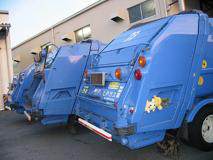

In [51]:
# Now the second item
ll.train[0][0]

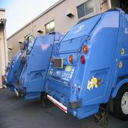

In [52]:
# Let's resize the image to 128x128
ll.train[0][0].resize((128,128))

- We will now make a class for resizing our images.
- It is important to note that resizing should take part _AFTER_ other transformation operations.

In [54]:
class ResizeFixed(Transform): # Carry out Bilinear resizing
    _order=10
    
    def __init__(self, size):
        if isinstance(size, int): 
            size=(size, size)
        self.size = size
        
    def __call__(self, item):
        return item.resize(self.size, PIL.Image.BILINEAR)
    
def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w, h = item.size
    return res.view(h, w, -1).permute(2, 0, 1) #Pillow and PyTorch handle permute differently
                                               # this can be seen in the cell below
# Here we can giving to_byte_tensor and to_float_tensor "class level state"
# i.e. we can attach a state to a function, which is underused in Python but is
# very useful
to_byte_tensor._order=20

def to_float_tensor(item):
    return item.float().div_(255.) # we divide by 255 to ensure the value is between 0 and 1

to_float_tensor._order=30

In [56]:
# Passing the list of tfms
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [57]:
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0)) # Here the channel comes in last

In [65]:
x, y = ll.train[0]
x.shape

torch.Size([3, 128, 128])

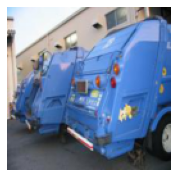

In [66]:
show_image(x)

## Modeling

### DataBunch

We will now put our datasets in the DataBunch.

In [67]:
bs = 64

In [69]:
train_dl, valid_dl = get_dls(ll.train, ll.valid, bs, num_workers=4)

In [70]:
x, y = next(iter(train_dl))

In [71]:
x.shape

torch.Size([64, 3, 128, 128])

'n03417042'

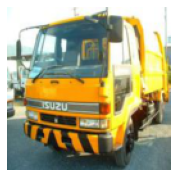

In [72]:
# Images can be viewed in the batch, plus their corresponding classes
show_image(x[0])
ll.train.proc_y.vocab[y[0]]

In [73]:
y

tensor([0, 7, 3, 1, 8, 9, 3, 2, 2, 4, 3, 6, 0, 9, 0, 5, 4, 4, 1, 7, 2, 8, 1, 2,
        3, 3, 9, 1, 9, 2, 9, 3, 1, 3, 7, 7, 0, 7, 3, 4, 2, 2, 0, 6, 0, 8, 6, 6,
        2, 7, 4, 5, 1, 5, 6, 8, 1, 8, 1, 0, 8, 9, 9, 2])